# Building your own DCGAN

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
from numpy import expand_dims
import h5py

In [2]:
images_size= (64,64)

In [3]:
def data_extract(images_size,BATCH_SIZE=20):
    x_start = int((100-images_size[0])/2)
    x_limit=(x_start,x_start+images_size[0])
    print(x_limit)
    y_start = int((160-images_size[1])/2)
    y_limit=(y_start,y_start+images_size[1])
    print(y_limit)

    a = np.load("C:\\Users\\KRISHNA\\Desktop\\ALL GAN FINAL\\Dataset_19200_train_4800_test\\Dataset_19200_train_4800_test.npz","r")
    x1 = a["X_train"]
    x1d = x1[:,x_limit[0]:x_limit[1],y_limit[0]:y_limit[1]] # [:,18:82,48:112]
    x1d = x1d/ 255.0
    y1 = a["y_train"]
    lbl_len_y1 = y1.shape[0]
    remain_y1 = lbl_len_y1 % BATCH_SIZE
    print(remain_y1) 
    x2 = a["X_test"]
    x2d = x2[:,x_limit[0]:x_limit[1],y_limit[0]:y_limit[1]] #  [:,18:82,48:112]
    x2d = x2d / 255.0
    y2 = a["y_test"]
    lbl_len_y2 = y2.shape[0]
    remain_y2 = lbl_len_y2 % BATCH_SIZE
    print(remain_y2)  
    train_list = list()
    test_list = list()
    for i in range(y1.shape[0]-remain_y1):
        d=x1d[i]
        lb1= y1[i]
        d1 = expand_dims(d, axis=0)
        train_list.append((d1,lb1))
    for j in range(y2.shape[0]-remain_y2):
        c=x2d[j]
        lb2= y2[j]
        c1 = expand_dims(c, axis=0)
        test_list.append((c1,lb2))
    ysort = list(set(y1))
    print(ysort)
    data = (train_list,test_list)
    return data,ysort

BATCH_SIZE = 100
(train_dataset,test_dataset),label_list=data_extract(images_size,BATCH_SIZE)
print(len(train_dataset),len(test_dataset))

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

len(train_dataloader), len(test_dataloader)
imgs, labels = next(iter(train_dataloader))
print(imgs.shape, labels.shape)


(18, 82)
(48, 112)
0
0
[0, 1, 2, 3]
19200 4800
torch.Size([100, 1, 64, 64]) torch.Size([100])


In [4]:
## Model
import torch
import torch.nn as nn

### Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, channels,images_size):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=128*(int(images_size[0]/4))*(int(images_size[1]/4))),  #7x7/25*40/16*16
            nn.ReLU(inplace=True),
            
            nn.Unflatten(dim=1, unflattened_size=(128, int((images_size[0]/4)), int((images_size[1]/4)))),
            
            nn.Upsample(scale_factor=2),  #14x14/50*80/32*32
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.8),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2), #28x28/100*160/64*64
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64, momentum=0.8),
            nn.ReLU(inplace=True),            
            
            nn.Conv2d(in_channels=64, out_channels=channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, z):
        return self.model(z)
            
### Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels,images_size):
        super(Discriminator, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3, stride=2, padding=1), #14x14
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), #7x7
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), #4x4
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), #4x4
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(int(images_size[0]/8))*(int(images_size[1]/8))*256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.classifier(self.features(x))
    
## Loss, Optimizer, Metrics
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


In [5]:
# Hyperparameters
latent_dim = 100
channels = 1
epochs = 30
lr = 0.0002
beta1 = 0.5
# Loss function
adversarial_loss = nn.BCELoss()
# Initialize generator and discriminator
generator = Generator(latent_dim, channels,images_size).to(device)
discriminator = Discriminator(channels,images_size).to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

from torchinfo import summary
summary(model=generator, input_size=(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 64, 64]            --
├─Sequential: 1-1                        [1, 1, 64, 64]            --
│    └─Linear: 2-1                       [1, 32768]                3,309,568
│    └─ReLU: 2-2                         [1, 32768]                --
│    └─Unflatten: 2-3                    [1, 128, 16, 16]          --
│    └─Upsample: 2-4                     [1, 128, 32, 32]          --
│    └─Conv2d: 2-5                       [1, 128, 32, 32]          147,584
│    └─BatchNorm2d: 2-6                  [1, 128, 32, 32]          256
│    └─ReLU: 2-7                         [1, 128, 32, 32]          --
│    └─Upsample: 2-8                     [1, 128, 64, 64]          --
│    └─Conv2d: 2-9                       [1, 64, 64, 64]           73,792
│    └─BatchNorm2d: 2-10                 [1, 64, 64, 64]           128
│    └─ReLU: 2-11                        [1, 64, 64, 64]           

In [6]:
summary(model=discriminator, input_size=(1, 1, images_size[0], images_size[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 256, 8, 8]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           320
│    └─LeakyReLU: 2-2                    [1, 32, 32, 32]           --
│    └─Dropout: 2-3                      [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 16, 16]           128
│    └─LeakyReLU: 2-6                    [1, 64, 16, 16]           --
│    └─Dropout: 2-7                      [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 128, 8, 8]            73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 8, 8]            256
│    └─LeakyReLU: 2-10                   [1, 128, 8, 8]            --
│    └─Dropout: 2-11                     [1, 128, 8, 8]            --
│   

In [7]:
## Training
# Training loop
for epoch in range(epochs):
    for (imgs,_) in train_dataloader:
        
        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1)).to(device)
        fake = torch.zeros((imgs.size(0), 1)).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        z = torch.randn((BATCH_SIZE, latent_dim)).to(device)
        # Train Generator
        optimizer_G.zero_grad()
        gen_imgs = generator(z)
        #print(gen_imgs.shape)
        #print(discriminator(gen_imgs).shape)
        # disc = discriminator(gen_imgs)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        #print(g_loss)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Print loss
    print(f"EPOCH: {epoch+1} | D_Loss: {d_loss.item():.5f} | G_Loss: {g_loss.item():.5f}")
print("Training Completed")

EPOCH: 0 | D_Loss: 0.53311 | G_Loss: 0.89848
EPOCH: 1 | D_Loss: 0.56494 | G_Loss: 0.61952
EPOCH: 2 | D_Loss: 0.38765 | G_Loss: 1.37682
EPOCH: 3 | D_Loss: 0.60288 | G_Loss: 1.32429
EPOCH: 4 | D_Loss: 0.55376 | G_Loss: 0.80263
EPOCH: 5 | D_Loss: 0.45680 | G_Loss: 1.17800
EPOCH: 6 | D_Loss: 0.43781 | G_Loss: 1.23800
EPOCH: 7 | D_Loss: 0.51582 | G_Loss: 0.81008
EPOCH: 8 | D_Loss: 0.54066 | G_Loss: 1.28977
EPOCH: 9 | D_Loss: 0.54247 | G_Loss: 1.59232
EPOCH: 10 | D_Loss: 0.49866 | G_Loss: 0.90138
EPOCH: 11 | D_Loss: 0.66225 | G_Loss: 0.41721
EPOCH: 12 | D_Loss: 0.45870 | G_Loss: 2.28281
EPOCH: 13 | D_Loss: 0.30444 | G_Loss: 1.88437
EPOCH: 14 | D_Loss: 0.36406 | G_Loss: 1.89232
EPOCH: 15 | D_Loss: 0.34125 | G_Loss: 1.81203
EPOCH: 16 | D_Loss: 0.37388 | G_Loss: 1.44089
EPOCH: 17 | D_Loss: 0.33863 | G_Loss: 1.09260
EPOCH: 18 | D_Loss: 0.31670 | G_Loss: 1.44819
EPOCH: 19 | D_Loss: 0.54133 | G_Loss: 0.78012
EPOCH: 20 | D_Loss: 0.60908 | G_Loss: 3.91377
EPOCH: 21 | D_Loss: 0.21701 | G_Loss: 1.9157

In [8]:
def test(dataloader, model, loss_fn,device,gen_imgs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model=model.to(device)
    fake = torch.zeros(gen_imgs.size(0), 1).to(device)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, yin in dataloader:
            y_list=[]
            #print(X[0],end=" ")
            #print(X.shape)
            for i in range(yin.shape[0]):
                yid=list()
                yid.append(yin[i].item())
                y_list.append([1])
            y=torch.Tensor(y_list)
            X,y = X.to(device),y.to(device)
            pred = model(X)
            #print(y,end=" ")
            #print(y.shape)
            test_loss += loss_fn(pred,y).item()
            # print(test_loss,end=" ")
            correct += (pred.argmax()).type(torch.float).sum().item()
            #print(pred,end=" ")
            #print(yin.shape)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
test(test_dataloader, discriminator, adversarial_loss,device,gen_imgs)

cuda
Test Error: 
 Accuracy: 43.0%, Avg loss: 0.525983 



cuda
torch.Size([1, 100])


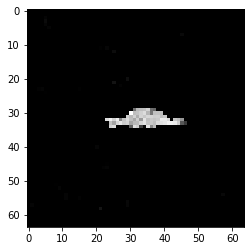

In [9]:
## Save the model
import os

model_save_path = "./models/"
model_name = f"dcgan_radar_{epochs}.pt"
torch.save({"generator_state_dict": generator.state_dict(),
            "discriminator_state_dict": discriminator.state_dict()},
           os.path.join(model_save_path, model_name))
## Load the model
model_trained = torch.load(os.path.join(model_save_path, model_name))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
latent_dim = 100
generator_loaded = Generator(latent_dim, channels,images_size)
generator_loaded.load_state_dict(model_trained["generator_state_dict"])
generator_loaded = generator_loaded.to(device)
## Inferences
torch.manual_seed(42)
torch.cuda.manual_seed(42)
### Single
noise_test = torch.randn(latent_dim)
noise_test.unsqueeze_(dim=0)
print(noise_test.shape)
noise_test = noise_test.to(device)
generator_loaded.eval()

with torch.inference_mode():
    gan_img_test = generator_loaded(noise_test)
    
gan_img_test.shape
gan_img_test = gan_img_test.squeeze().to('cpu').detach().numpy()
import matplotlib.pyplot as plt

plt.imshow(gan_img_test, cmap='gray')


Image 25.png saved


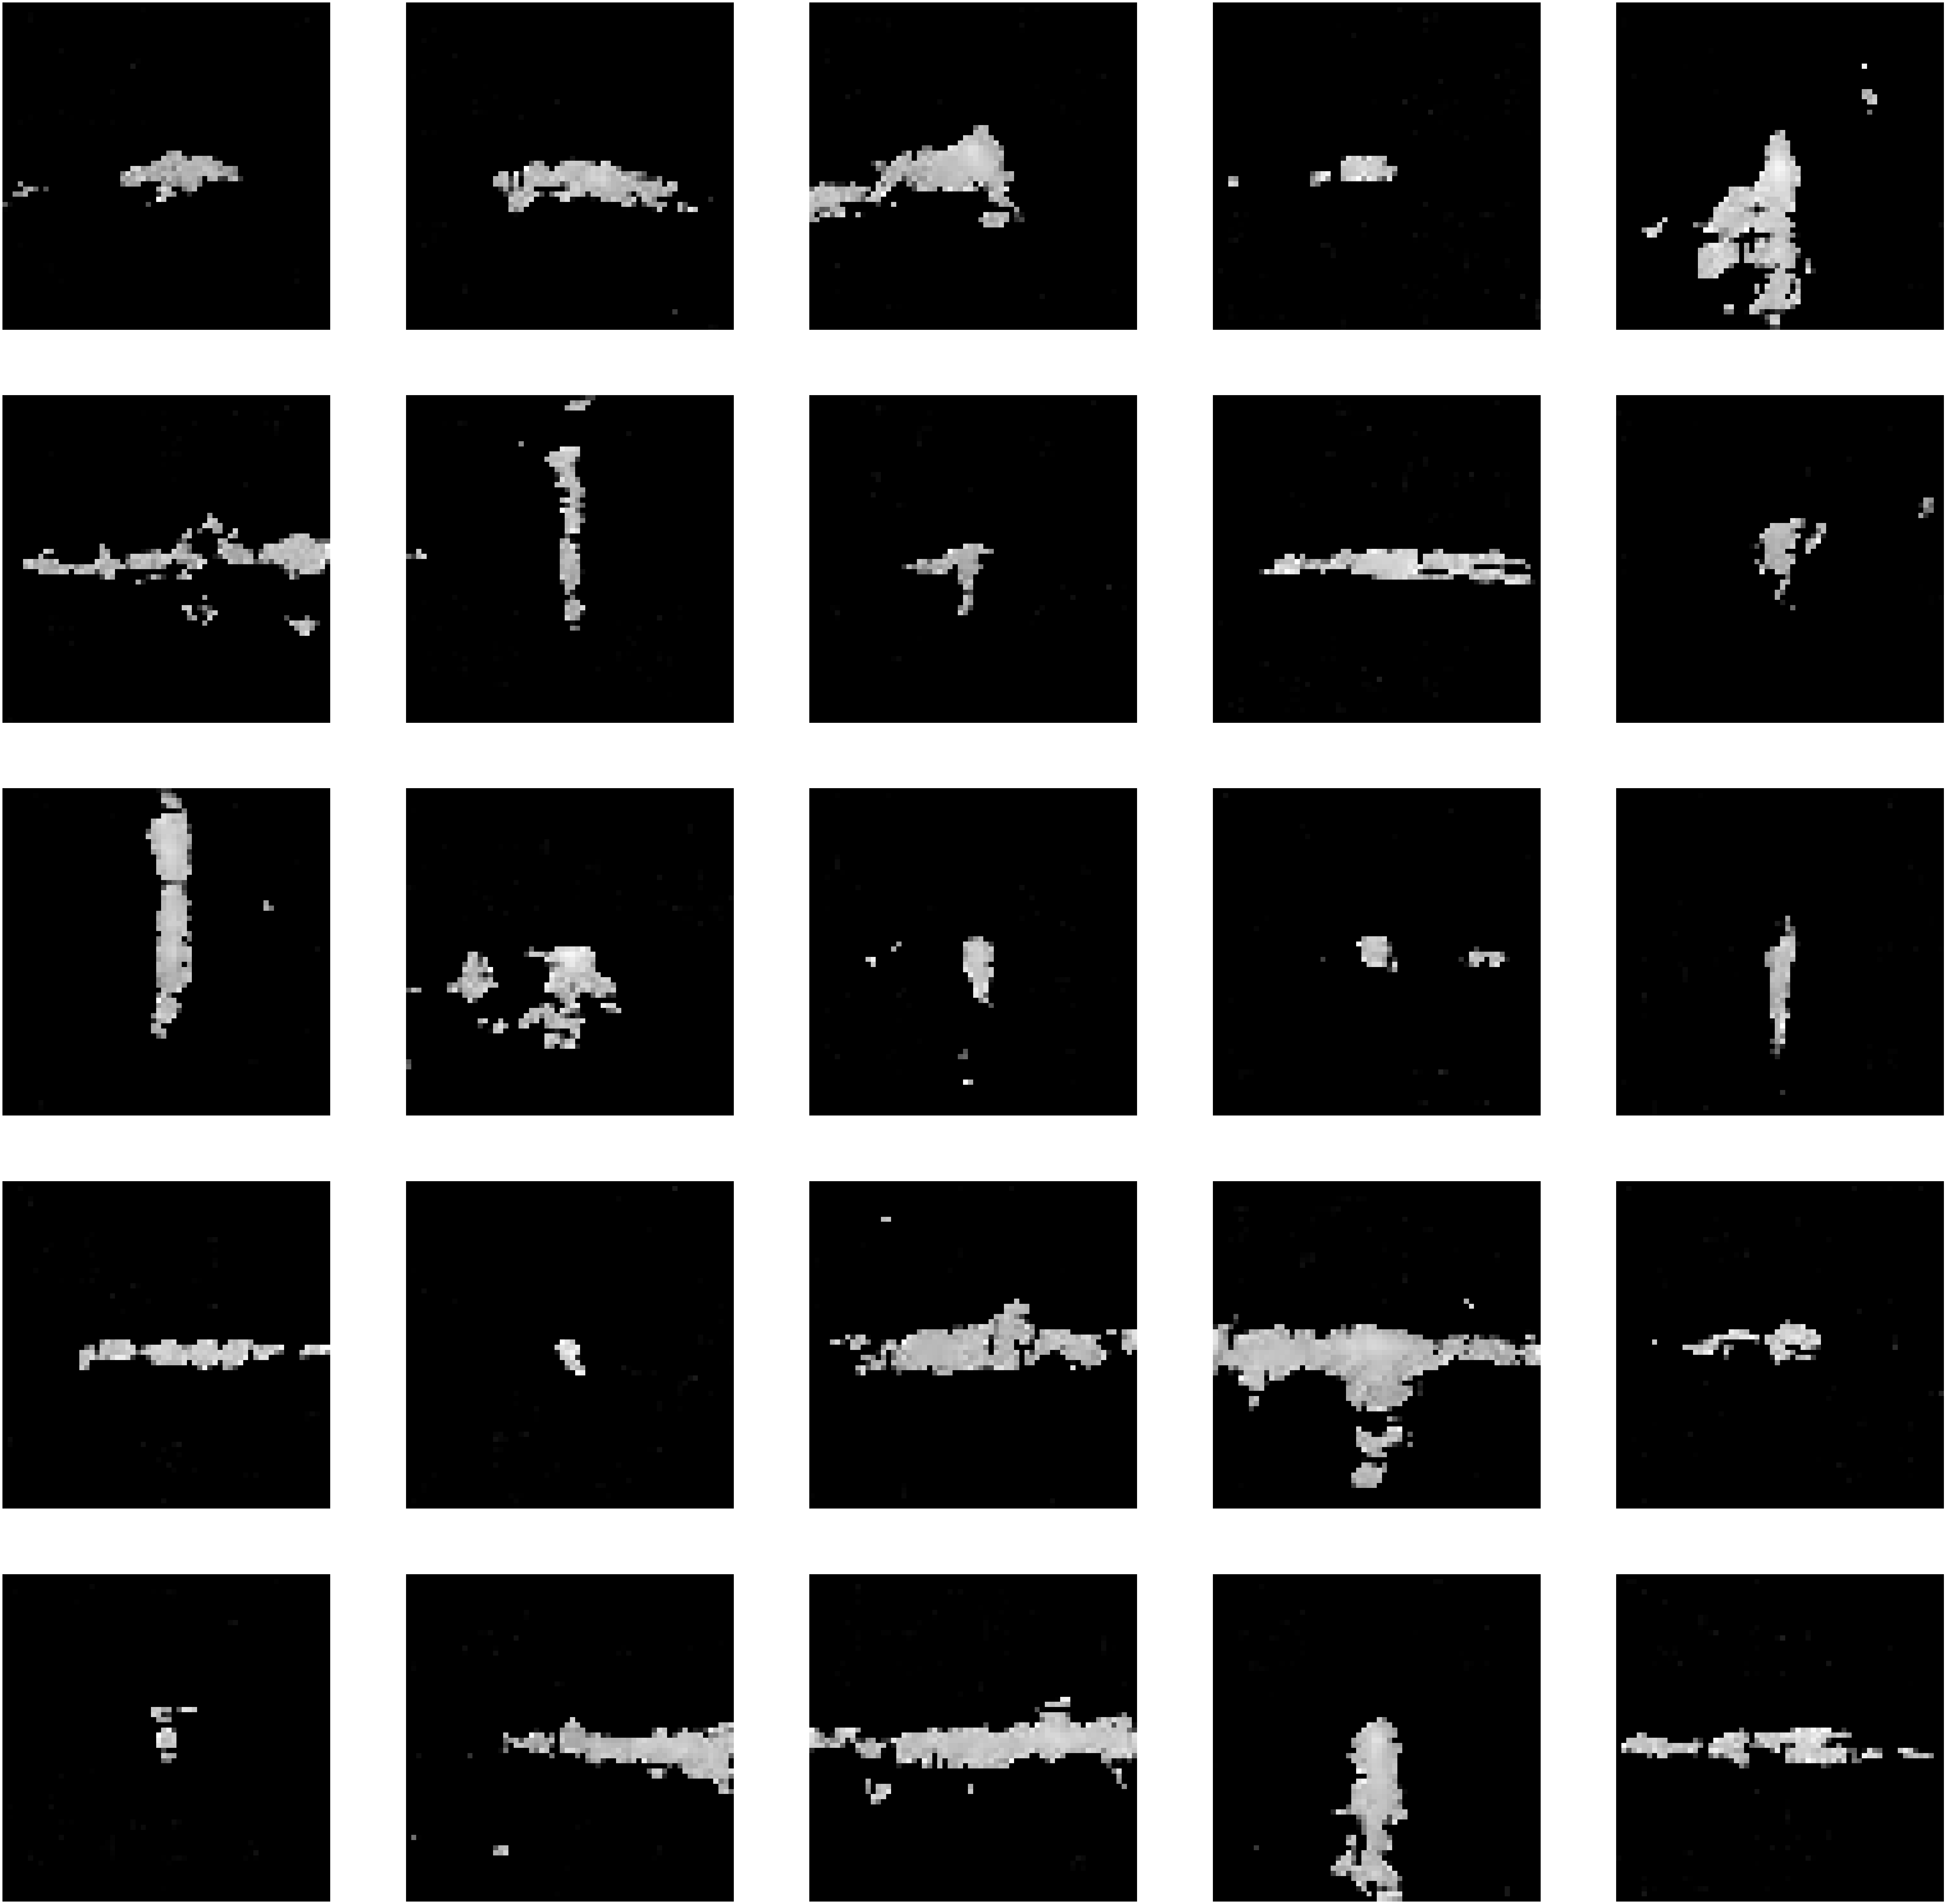

In [10]:
### Multiple Image maker
torch.manual_seed(42)
torch.cuda.manual_seed(42)
examples = 100
latent_dim = 100

noise_inputs = torch.randn(examples, latent_dim)
noise_inputs.shape
generator_loaded.eval()

rows = 5
cols = 5

fig = plt.figure(figsize=(100, 100))
for i in range(1, (rows * cols) + 1):
    noise_input = noise_inputs[i-1]
    noise_input = noise_input.unsqueeze_(dim=0).to(device)
    with torch.inference_mode():
        gan_output = generator_loaded(noise_input)
    gan_output = gan_output.squeeze().to('cpu').detach().numpy()
    fig.add_subplot(rows, cols, i)
    plt.imshow(gan_output, cmap='gray')
    plt.axis(False)
    
plt.savefig(f'{model_save_path}{i}.png')
print(f"Image {i}.png saved")


In [11]:
### Npz Maker
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
examples = 10000
latent_dim = 100

noise_inputs = torch.randn(examples, latent_dim)
noise_inputs.shape
generator_loaded.eval()

gen_images_list =list()

for i in range(examples):
    noise_input = noise_inputs[i]
    noise_input = noise_input.unsqueeze_(dim=0).to(device)
    with torch.inference_mode():
        gan_output = generator_loaded(noise_input)
    gan_output = gan_output.squeeze().to('cpu').detach().numpy()
    #print(type(gan_output[:]))
    gen_images_list.append(gan_output)
Gen_images=np.array(gen_images_list)
print(Gen_images.shape)
np.savez(f'DCGAN_Generated_Images_{examples}.npz',images=Gen_images)
print(f"Image generated") 

cuda
(10000, 64, 64)
Image generated
